# Customizing visualizations

## About the Data
In this notebook, we will be working with 2 datasets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis))
- Earthquake data from September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/))

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

fb = pd.read_csv(
    'data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True
)

quakes = pd.read_csv('data/earthquakes.csv')

## Adding reference lines
### Horizontal reference lines
`axhline()` adds horizontal lines. We simply specify the y value to draw the horizontal line at with the `y` parameter. Optionally, we can provide:
- `label` for a string that will show up in the legend
- `color` for the color of the reference line
- `linestyle` for the type of line to draw

We will draw reference lines for support and resistance using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis) that we will build in chapter 7. To get these metrics, we need to create a `StockAnalyzer` object:

In [2]:
from stock_analysis import StockAnalyzer

fb_analyzer = StockAnalyzer(fb)

With the `fb_analyzer` we can use the `support()` and `resistance()` methods to get the values we seek:

In [3]:
support, resistance = (
    getattr(fb_analyzer, stat)(level=3) for stat in ['support', 'resistance']
)
support, resistance

(124.4566666666667, 138.5266666666667)

Now that we have the values, we can add our reference lines with `plt.axhline()`:

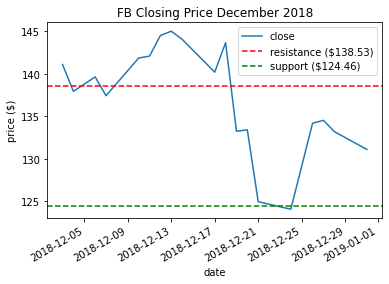

In [4]:
fb.close['2018-12'].plot(title='FB Closing Price December 2018')
plt.axhline(
    y=resistance, color='r', linestyle='--',
    label=f'resistance (${resistance:,.2f})'
)
plt.axhline(
    y=support, color='g', linestyle='--',
    label=f'support (${support:,.2f})'
)
plt.ylabel('price ($)')
plt.legend()

### Vertical reference lines
For vertical lines, we use `axvline()` and provide the `x` parameter for where to draw it. The `std_from_mean_kde()` function draws vertical reference lines using `axvline()` at each standard deviation from the mean (1-3) and the mean.

In [5]:
from viz import std_from_mean_kde
std_from_mean_kde??

Signature: std_from_mean_kde(data)
Source:   
def std_from_mean_kde(data):
    """
    Plot the KDE along with vertical reference lines
    for each standard deviation from the mean.
    
    Parameters:
        - data: `pandas.Series` with numeric data
    
    Returns:
        Matplotlib `Axes` object.
    """
    mean_mag, std_mean = data.mean(), data.std()
    
    ax = data.plot(kind='kde')
    ax.axvline(mean_mag, color='b', alpha=0.2, label='mean')
    
    colors = ['green', 'orange', 'red']
    multipliers = [1, 2, 3]
    signs = ['-', '+']
    linestyles = [':', '-.', '--']
    
    for sign, (color, multiplier, style) in itertools.product(
        signs, zip(colors, multipliers, linestyles)
    ):
        adjustment = multiplier * std_mean
        if sign == '-':
            value = mean_mag - adjustment
            label = '{} {}{}{}'.format(
                r'$\mu$',
                r'$\pm$',
                multiplier,
                r'$\sigma$'
            )
        els

Note, we need to import it from the `viz.py` module, before we can use it.

Text(0.5, 0, 'mb earthquake magnitude')

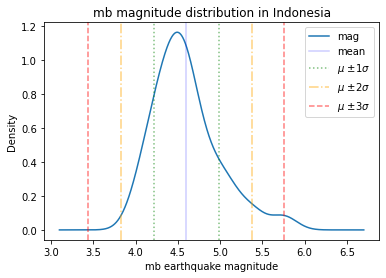

In [6]:
from viz import std_from_mean_kde

ax = std_from_mean_kde(
    quakes.query(
        'magType == "mb" and parsed_place == "Indonesia"'
    ).mag
)
ax.set_title('mb magnitude distribution in Indonesia')
ax.set_xlabel('mb earthquake magnitude')

## Shading regions
We can use `axhspan()` and `axvspan()` to shade horizontal and vertical regions, respectively.

Text(0, 0.5, 'Price ($)')

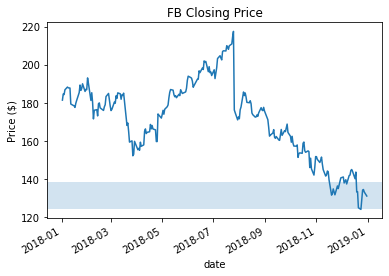

In [7]:
ax = fb.close.plot(title='FB Closing Price')
ax.axhspan(support, resistance, alpha=0.2)
plt.ylabel('Price ($)')

Rather than filling in a rectangular region, we can fill between two curves using `plt.fill_between()`:

Text(0.5, 1.0, 'FB differential between high and low price Q4 2018')

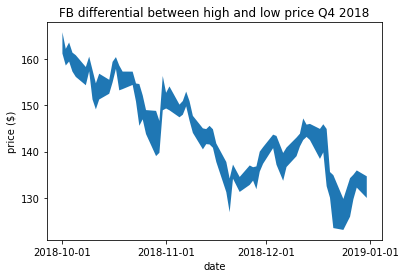

In [8]:
fb_q4 = fb.loc['2018-Q4']
plt.fill_between(fb_q4.index, fb_q4.high, fb_q4.low)
plt.xticks(['2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'])
plt.xlabel('date')
plt.ylabel('price ($)')
plt.title('FB differential between high and low price Q4 2018')

We can specify a specific range to fill with the `where` argument:

Text(0.5, 1.0, 'FB differential between high and low price Q4 2018')

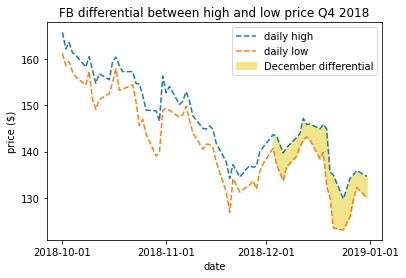

In [9]:
fb_q4 = fb.loc['2018-Q4']
plt.fill_between(
    fb_q4.index, fb_q4.high, fb_q4.low, 
    where=fb_q4.index.month == 12, 
    color='khaki', label='December differential'
)
plt.plot(fb_q4.index, fb_q4.high, '--', label='daily high')
plt.plot(fb_q4.index, fb_q4.low, '--', label='daily low')
plt.xticks(['2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'])
plt.xlabel('date')
plt.ylabel('price ($)')
plt.legend()
plt.title('FB differential between high and low price Q4 2018')

## Annotations
The `plt.annotate()` function can be used to add annotation to plots. Some important arguments:
- `xy`: a tuple of the coordinates to annotate
- `xytext`: a tuple of coordinates of where to place the annotation text
- `arrowprops`: a dictionary of how to draw the arrow from the text of the annotation to the point being annotated
- `ha`/`va`: specify the horizontal/vertical alignment

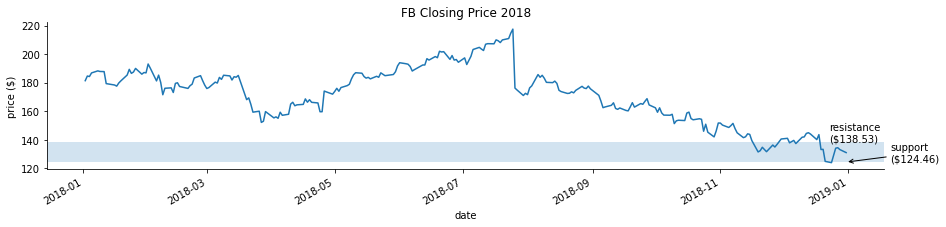

In [10]:
ax = fb.close.plot(title='FB Closing Price 2018', figsize=(15, 3))
ax.set_ylabel('price ($)')

ax.axhspan(support, resistance, alpha=0.2)

plt.annotate(
    f'support\n(${support:,.2f})',
    xy=('2018-12-31', support),
    xytext=('2019-01-21', support),
    arrowprops={'arrowstyle': '->'}
)
plt.annotate(
    f'resistance\n(${resistance:,.2f})',
    xy=('2018-12-23', resistance)
)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

We have many options for the arrow:

Text(0, 0.5, 'price ($)')

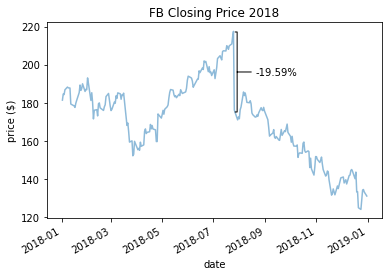

In [11]:
close_price = fb.loc['2018-07-25', 'close']
open_price = fb.loc['2018-07-26', 'open']
pct_drop = (open_price - close_price) / close_price
fb.close.plot(title='FB Closing Price 2018', alpha=0.5)
plt.annotate(
    f'{pct_drop:.2%}', va='center',
    xy=('2018-07-27', (open_price + close_price) / 2),
    xytext=('2018-08-20', (open_price + close_price) / 2),
    arrowprops=dict(arrowstyle='-[,widthB=4.0,lengthB=0.2')
)
plt.ylabel('price ($)')

We can also pass additional parameters down to the [`matplotlib.text.Text` class](https://matplotlib.org/api/text_api.html#matplotlib.text.Text), such as `color`, `fontfamily`, `fontsize`, and `fontweight`:

Text(0, 0.5, 'price ($)')

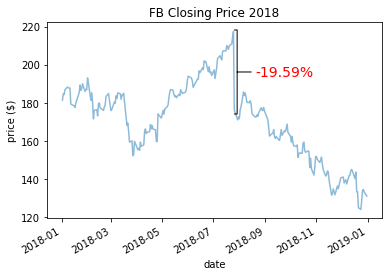

In [12]:
close_price = fb.loc['2018-07-25', 'close']
open_price = fb.loc['2018-07-26', 'open']
pct_drop = (open_price - close_price) / close_price

fb.close.plot(title='FB Closing Price 2018', alpha=0.5)

plt.annotate(
    f'{pct_drop:.2%}', va='center',
    xy=('2018-07-27', (open_price + close_price) / 2),
    xytext=('2018-08-20', (open_price + close_price) / 2),
    arrowprops=dict(arrowstyle='-[,widthB=3.0,lengthB=0.2'),
    color='red',
    fontsize=14,
    fontweight='medium'
)
plt.ylabel('price ($)')

## Colors
We can pass colors to the `color` argument of the `plot()` method. This can be a color name, a hex code, or RGB values.

Text(0, 0.5, 'price ($)')

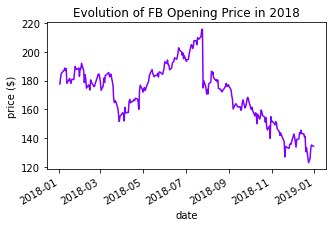

In [13]:
fb.plot(
    y='open',
    figsize=(5, 3),
    color='#8000FF',
    legend=False,
    title='Evolution of FB Opening Price in 2018'
)
plt.ylabel('price ($)')

RGB values must be given as decimals:

Text(0, 0.5, 'price ($)')

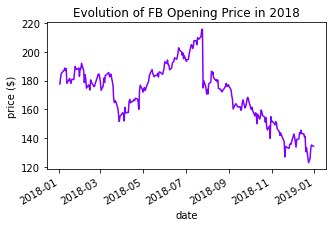

In [14]:
fb.plot(
    y='open',
    figsize=(5, 3),
    color=(128 / 255, 0, 1),
    legend=False,
    title='Evolution of FB Opening Price in 2018'
)
plt.ylabel('price ($)')

### Colormaps
| Class | Purpose |
| --- | --- |
| Qualitative | No ordering or relationship between colors; just used to distinguish between groups |
| Sequential | For information with ordering, such as temperature |
| Diverging | There is a middle value between two extremes that has meaning; for example, correlation coefficients are bounded in the range `[-1, 1]`, and `0` has meaning (no correlation) |

#### Finding available colormaps

In [15]:
from matplotlib import cm
cm.datad.keys()

dict_keys(['Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'])

We can pass a colormap to the `colormap` argument:

Text(0, 0.5, 'price ($)')

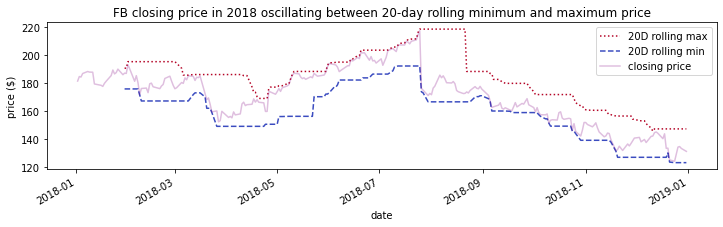

In [16]:
ax = fb.assign(
    rolling_min=lambda x: x.low.rolling(20).min(),
    rolling_max=lambda x: x.high.rolling(20).max()
).plot(
    y=['rolling_max', 'rolling_min'], 
    colormap='coolwarm_r', 
    label=['20D rolling max', '20D rolling min'],
    style=[':', '--'],
    figsize=(12, 3),
    title='FB closing price in 2018 oscillating between '
          '20-day rolling minimum and maximum price'
)
ax.plot(fb.close, 'purple', alpha=0.25, label='closing price')
plt.legend()
plt.ylabel('price ($)')

We can also grab colors out of a colormap, which is a callable. This gives us an RGBA color, which we already know can be used as the `color` for the plot:

In [17]:
cm.get_cmap('ocean')(.5)

(0.0, 0.2529411764705882, 0.5019607843137255, 1.0)

#### Making colormaps
In order to make colormaps, we need some utility functions which can be found in the `color_utils.py` module. We will need to be able to convert hex colors to RGBA decimals, blend colors to build a colormap, and draw the colormap.

In [18]:
import color_utils

##### Blended colormaps
Use `blended_cmap()` to blend any number of colors:

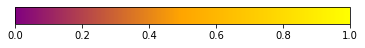

In [19]:
my_colors = ['#800080', '#FFA500', '#FFFF00']
rgbs = color_utils.hex_to_rgb_color_list(my_colors)
my_cmap = color_utils.blended_cmap(rgbs)
color_utils.draw_cmap(my_cmap, orientation='horizontal')

*Note: The `draw_cmap()` function also makes it easy to add a colorbar with our own colormap to the plot of our choice. Check out the [`covid19_cases_map.ipynb`](./covid19_cases_map.ipynb) notebook to see this in action.*

#### Seaborn Color Palettes
Seaborn also provides additional color palettes, along with utility functions for picking colormaps and making custom ones interactively in Jupyter. See [this tutorial](https://seaborn.pydata.org/tutorial/color_palettes.html) for more information.

##### Showing a color palette

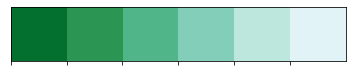

In [20]:
import seaborn as sns

sns.palplot(sns.color_palette("BuGn_r"))

##### Building a color palette interactively for use with matplotlib

In [21]:
diverging_cmap = sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

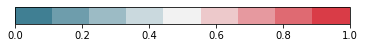

In [22]:
from matplotlib.colors import ListedColormap
color_utils.draw_cmap(ListedColormap(diverging_cmap), orientation='horizontal')

#### Cycling through colors
We can use itertools to cycle through colors:

In [23]:
import itertools

colors = itertools.cycle(['#ffffff', '#f0f0f0', '#000000'])
colors

In [24]:
next(colors)

'#ffffff'

Or we can work with a `ListedColormap` object:

In [25]:
from matplotlib.colors import ListedColormap
red_black = ListedColormap(['red', 'black'], N=2000)
[red_black(i) for i in range(3)]

[(1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0), (1.0, 0.0, 0.0, 1.0)]

We may also consider using a generator:

In [26]:
def color_generator():
    for year in range(1992, 200019): # integers in [1992, 200019)
        if year % 100 == 0 and year % 400 != 0:
            # special case (divisible by 100 but not 400)
            color = '#f0f0f0'
        elif year % 4 == 0:
            # leap year (divisible by 4)
            color = '#000000'
        else:
            color = '#ffffff'
        yield color
    
year_colors = color_generator()
year_colors

<generator object color_generator at 0x7bef148dfed0>

In [27]:
next(year_colors)

'#000000'

We can also make a generator with a generator expression:

In [28]:
year_colors = (
    '#ffffff'
    if (not year % 100 and year % 400) or year % 4
    else '#000000' for year in range(1992, 200019)
)
year_colors

<generator object <genexpr> at 0x7bef14415138>

In [29]:
next(year_colors)

'#000000'

## Textures
We can add textures to our plots via the `hatch` parameter in `matplotlib`. Current options are: {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}

[Text(0.5, 0, 'week number'), Text(0, 0.5, 'volume traded')]

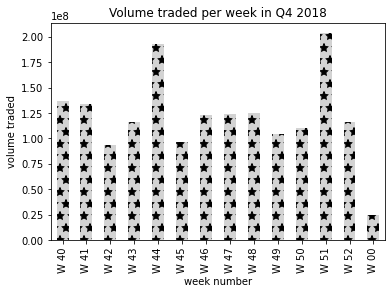

In [30]:
weekly_volume_traded = fb.loc['2018-Q4'].groupby(pd.Grouper(freq='W')).volume.sum()
weekly_volume_traded.index = weekly_volume_traded.index.strftime('W %W')
ax = weekly_volume_traded.plot(
    kind='bar', hatch='*', color='lightgray',
    title='Volume traded per week in Q4 2018'
)
ax.set(xlabel='week number', ylabel='volume traded')

We can combine textures to create new ones and repeat them to intensify the effect:

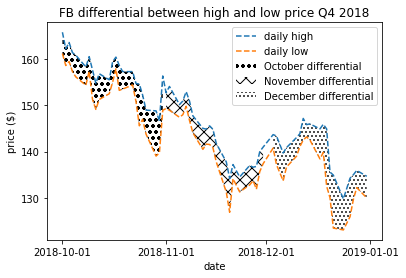

In [31]:
import calendar

fb_q4 = fb.loc['2018-Q4']

for texture, month in zip(['oo', '/\\/\\', '...'], [10, 11, 12]):
    plt.fill_between(
        fb_q4.index, fb_q4.high, fb_q4.low, hatch=texture, 
        where=fb_q4.index.month == month, facecolor='white',
        label=f'{calendar.month_name[month]} differential'
    )

plt.plot(fb_q4.index, fb_q4.high, '--', label='daily high')
plt.plot(fb_q4.index, fb_q4.low, '--', label='daily low')
plt.xticks(['2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'])
plt.xlabel('date')
plt.ylabel('price ($)')
plt.title('FB differential between high and low price Q4 2018')
plt.legend()

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
         <a href="./2-formatting_plots.ipynb">
        <button>&#8592; Previous Notebook</button>
    </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_06/solutions.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_07/financial_analysis.ipynb">
            <button>Chapter 7 &#8594;</button>
        </a>
    </div>
</div>
<hr>